In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import nest as sim
import numpy as np
import os
from scipy.io import loadmat

sim.ResetKernel()

sim_len = 700000

In [11]:
path = os.path.realpath('rat_trajectory_lowpass.mat')
ratData = loadmat(path)
rat_dt     = ratData['dt'][0][0]

x  = ratData['pos_x'].ravel()
y  = ratData['pos_y'].ravel()

dt = rat_dt*1000
t = np.arange(1,(len(x)*dt),dt)

In [12]:
def getGridCurrent (grid_space,pos_x,pos_y, start = np.array([0.,0.]), grid_phase = 0):
    env_rad = int(max(max(max(pos_x),max(pos_y)), abs(min(min(pos_x),min(pos_y)))))
    centers = np.array([start])
    for i in range(env_rad//grid_space+1):
        j=i+1
        y = np.around(np.sin(grid_phase)*(j*grid_space),2)
        x = np.around(np.cos(grid_phase)*(j*grid_space),2)
            
        # horizontal
        centers =np.vstack((centers,np.add(start,[x,y])))
        centers =np.vstack((centers,np.add(start,[-x,-y])))

    # 60 degrees
    c = np.array([start])
    for horz in centers:
        for i in range(env_rad//grid_space+1):
            j=i+1
            y = np.around(np.sin(grid_phase+(np.pi/3))*(j*grid_space),2)
            x = np.around(np.cos(grid_phase+(np.pi/3))*(j*grid_space),2)

            c =np.vstack((c,np.add(horz,[x,y])))
            c =np.vstack((c,np.add(horz,[-x,-y])))
            c =np.vstack((c,np.add(horz,[-x,y])))
            c =np.vstack((c,np.add(horz,[x,-y])))
    centers =np.unique(np.vstack((centers,c)),axis=0)

    sigma = grid_space/5
    current = np.zeros(len(pos_x))
    for center in centers:
        d = np.sqrt(np.power(center[0] - pos_x, 2) + np.power(center[1] - pos_y, 2))
        gauss = 150* np.exp(-(d)**2/2/sigma**2)
        current = np.add(current,gauss)
    return current

def plotGridCurrent (pos_x,pos_y,current):
    fig = plt.figure(figsize=(5, 5),facecolor='w')
    plt.scatter(pos_x, pos_y, c = current,cmap = 'jet')

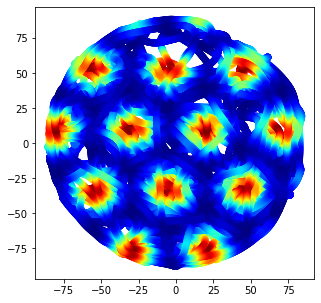

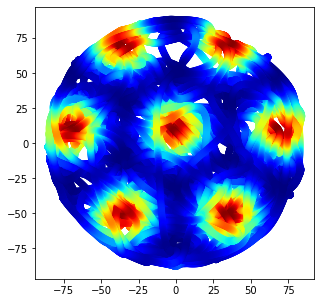

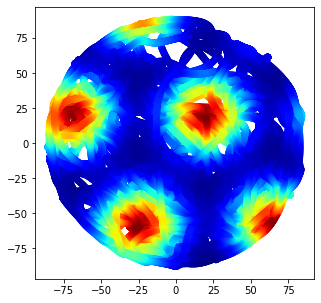

In [13]:
I40 = getGridCurrent(50,x,y, start = np.array([20.,10.]))
I60 = getGridCurrent(70,x,y, start = np.array([0.,10.]))
I80 = getGridCurrent(90,x,y, start = np.array([20.,20.]))

# I40 = getGridCurrent(50,x,y, start = np.array([20.,10.]))
# I60 = getGridCurrent(70,x,y, start = np.array([10.,10.]))
# I80 = getGridCurrent(90,x,y, start = np.array([20.,20.]))

# I40 = getGridCurrent(60,x,y, start = np.array([20.,10.]))
# I60 = getGridCurrent(80,x,y, start = np.array([10.,10.]))
# I80 = getGridCurrent(100,x,y, start = np.array([20.,20]))

plotGridCurrent(x,y,I40)
plotGridCurrent(x,y,I60)
plotGridCurrent(x,y,I80)


In [14]:
# fig = plt.figure(figsize=(20, 5),facecolor='w')
# plt.plot(t,I40)
# plt.plot(t,I60)
# plt.plot(t,I80)

# I40

In [15]:
PC = sim.Create("iaf_psc_alpha",1)

grid_in_40 = sim.Create('step_current_generator', 1)
sim.SetStatus(grid_in_40,{'amplitude_times': t,'amplitude_values': I40})

grid_in_60 = sim.Create('step_current_generator', 1)
sim.SetStatus(grid_in_60,{'amplitude_times': t,'amplitude_values': I60*1.2})

grid_in_80 = sim.Create('step_current_generator', 1)
sim.SetStatus(grid_in_80,{'amplitude_times': t,'amplitude_values': I80})

sim.Connect(grid_in_40,PC)
sim.Connect(grid_in_60,PC)
sim.Connect(grid_in_80,PC)


In [16]:
PC_spikes = sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True})
sim.Connect(PC,PC_spikes)

In [17]:
sim.Simulate(sim_len)

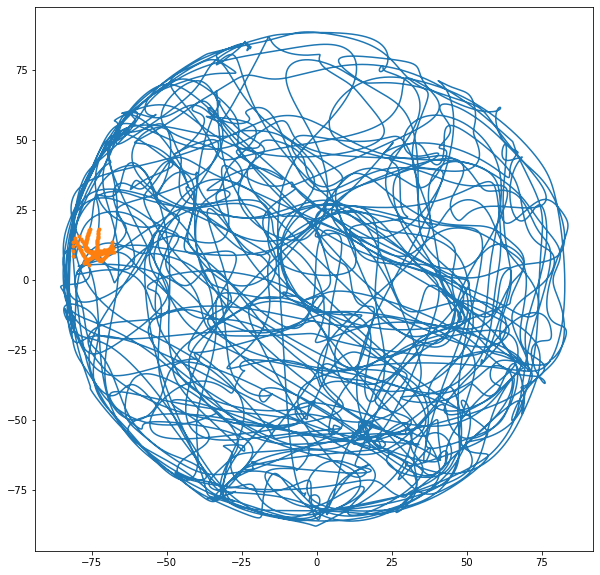

In [18]:
ev = sim.GetStatus(PC_spikes)[0]['events']
spktms = ev['times']
sp = ev['senders']

spktms = (spktms//20)*20
spktms=spktms[1:]

xs = np.empty((len(spktms)))
ys = np.empty((len(spktms)))

for i,spk in enumerate(spktms):
    if spk < max(t):
        xs[i] = x[np.where(t == spk+1)[0][0]]
        ys[i] = y[np.where(t == spk+1)[0][0]]

fig = plt.figure(figsize=(10, 10),facecolor='w')
plt.plot(x,y)
plt.plot(xs,ys,'.')